## Age prediction using MobileNet

## Installing the packages

In [1]:
import tensorflow.keras as K
import pandas as pd
import numpy as np
import os
import cv2
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

### Getting the data to a dataframe

In [2]:
df = pd.read_csv('/Users/manideepakreddyaila/Downloads/archive-2/train.csv')
df.head()
cond_list = [df['Class'] == 'MIDDLE', df['Class'] == 'YOUNG', df['Class'] == 'OLD']
choice_list = [1, 0, 2]

df["index"] = np.select(cond_list, choice_list)

### preprocessing the data

In [3]:
path = "/Users/manideepakreddyaila/Downloads/archive-2/Train"
images = []
age = []

for img in os.listdir(path):
    img1 = cv2.imread(str(path) + "/" + str(img))
#     img1.resize(100,100)
    img1 = cv2.resize(img1, (70,70), interpolation = cv2.INTER_AREA)
    img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
    images.append(np.array(img1))
    df1 = df[df['ID'] == str(img)]['index']
    ages = []
    ages.append((np.array(df1.values[0])))
    age.append(ages)

age = to_categorical(age, 3)
age = np.array(age)
print(type(age[0]))
print(type(age))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [4]:
images = np.array(images)

In [5]:
preprocessed_X = K.applications.resnet50.preprocess_input(images)

In [6]:
print(preprocessed_X.shape)

(19906, 70, 70, 3)


In [7]:
print(preprocessed_X[0])

[[[-75.939    -92.779    -87.68    ]
  [-71.939    -89.779    -83.68    ]
  [-68.939    -86.779    -80.68    ]
  ...
  [-63.939003 -79.779    -64.68    ]
  [-70.939    -86.779    -71.68    ]
  [-73.939    -89.779    -74.68    ]]

 [[-73.939    -89.779    -85.68    ]
  [-68.939    -85.779    -80.68    ]
  [-65.939    -83.779    -77.68    ]
  ...
  [-46.939003 -62.779    -47.68    ]
  [-54.939003 -70.779    -55.68    ]
  [-59.939003 -75.779    -60.68    ]]

 [[-71.939    -87.779    -82.68    ]
  [-65.939    -82.779    -77.68    ]
  [-62.939003 -80.779    -74.68    ]
  ...
  [-38.939003 -54.779    -39.68    ]
  [-46.939003 -62.779    -47.68    ]
  [-52.939003 -68.779    -53.68    ]]

 ...

 [[-81.939    -92.779    -81.68    ]
  [-78.939    -88.779    -77.68    ]
  [-74.939    -85.779    -74.68    ]
  ...
  [-60.939003 -71.779    -48.68    ]
  [-60.939003 -71.779    -48.68    ]
  [-56.939003 -67.779    -44.68    ]]

 [[-80.939    -91.779    -80.68    ]
  [-77.939    -88.779    -77.68    ]


In [8]:
print(age.shape)

(19906, 3)


## MobileNet Model

In [9]:
inp = K.Input(shape=(70,70,3))
res_model = K.applications.MobileNet(include_top=False, weights='imagenet', input_tensor = inp)

2022-12-14 11:23:03.582321: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
res_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 70, 70, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 35, 35, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 35, 35, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 35, 35, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 35, 35, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 35, 35, 32)       128       
 ation)                                         

In [11]:
model = K.models.Sequential()
model.add(res_model)
model.add(K.layers.Flatten())
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dense(256, activation='relu'))
model.add(K.layers.Dropout(0.5))
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dense(128, activation='relu'))
model.add(K.layers.Dropout(0.5))
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dense(64, activation='relu'))
model.add(K.layers.Dropout(0.5))
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dense(3, activation='softmax'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 2, 2, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 batch_normalization (BatchN  (None, 4096)             16384     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               1048832   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1

In [13]:
model.compile(loss='categorical_crossentropy',
                  optimizer=K.optimizers.RMSprop(lr=2e-5),
                  metrics=['accuracy'])

/Users/manideepakreddyaila/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


### Train Test split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(preprocessed_X, age, random_state=42)

### Fitting the model

In [15]:
history = model.fit(X_train, y_train, batch_size=32, epochs=30, verbose=1,
                        validation_data=(X_test, y_test))

Epoch 1/30
467/467 [==============================] - 135s 283ms/step - loss: 1.5132 - accuracy: 0.3351 - val_loss: 0.9740 - val_accuracy: 0.5353
Epoch 2/30
467/467 [==============================] - 137s 293ms/step - loss: 1.4062 - accuracy: 0.3768 - val_loss: 0.9275 - val_accuracy: 0.5821
Epoch 3/30
467/467 [==============================] - 137s 293ms/step - loss: 1.3114 - accuracy: 0.4064 - val_loss: 0.8892 - val_accuracy: 0.6076
Epoch 4/30
467/467 [==============================] - 149s 318ms/step - loss: 1.2657 - accuracy: 0.4310 - val_loss: 0.8611 - val_accuracy: 0.6313
Epoch 5/30
467/467 [==============================] - 268s 575ms/step - loss: 1.2033 - accuracy: 0.4612 - val_loss: 0.8368 - val_accuracy: 0.6476
Epoch 6/30
467/467 [==============================] - 292s 625ms/step - loss: 1.1292 - accuracy: 0.4975 - val_loss: 0.8095 - val_accuracy: 0.6651
Epoch 7/30
467/467 [==============================] - 289s 619ms/step - loss: 1.0748 - accuracy: 0.5216 - val_loss: 0.7916 -

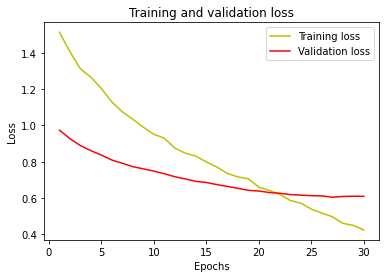

In [19]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

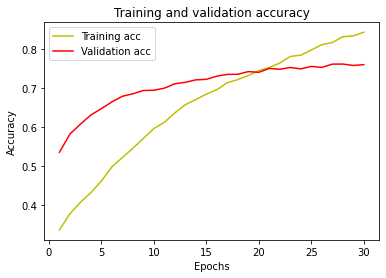

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()